# Final Project Submission for ECE225A
## Introduction 
We split this notebook into two parts: (1) exploratory data visualization and analysis, where we examine play-level and player-level distributions such as routes, pass outcomes, EPA (Expected Points Addded), spatial positioning, and clustering of early targeted-receiver trajectories based on their first few tracking frames, and (2) analysis of defensive closing speed during the ball-in-air phase, where we quantify receiver–defender separation, closing dynamics, and out-of-phase recovery behavior to study their relationship with incomplete passes.

The analysis uses the NFL Big Data Bowl 2026 Analytics dataset, which provides frame-level player tracking data split into an input segment before the pass is thrown and an output segment after the pass is thrown (ball-in-air window, ending when the pass arrives), along with a supplementary play-level table containing game/play context, route labels, pass outcomes, and expected points added (EPA)

Link to Github repo: https://github.com/glitched-shadeslayer/nfl-pass-play-analytics  

## I. EXPLORATORY DATA ANALYSIS

In [ ]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = 200
pd.options.display.max_rows = 100
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
DATA_DIR = Path("/Users/prabhleenkaur/Desktop/ECE225-NFL/114239_nfl_competition_files_published_analytics_final").expanduser()
TRAIN_DIR = DATA_DIR / "train"
SUPPLEMENTARY_PATH = DATA_DIR / "supplementary_data.csv"
input_files = sorted(TRAIN_DIR.glob("input_*.csv"))
output_files = sorted(TRAIN_DIR.glob("output_*.csv"))


### Data overview

In [ ]:
dfs = {}
plays = pd.read_csv(SUPPLEMENTARY_PATH, low_memory=False)
plays.columns = plays.columns.str.strip().str.replace("-", "_").str.replace(" ", "_")
dfs["plays"] = plays

WEEKS_TO_LOAD = sorted({int(fp.stem.split("_")[-1][1:]) for fp in (DATA_DIR / "train").glob("input_*.csv")})
tracking_frames = []
for w in WEEKS_TO_LOAD:
    fp = TRAIN_DIR / f"input_2023_w{w:02d}.csv"
    df = pd.read_csv(fp, low_memory=False)
    df["week"] = w
    tracking_frames.append(df)

tracking = pd.concat(tracking_frames, ignore_index=True)
tracking.columns = tracking.columns.str.strip().str.replace("-", "_").str.replace(" ", "_")

tracking = tracking.rename(
    columns={
        "nfl_id": "player_id",
        "player_name": "displayName",
        "player_position": "position",
        "player_side": "team",
    }
)
tracking["player_to_predict"] = tracking["player_to_predict"].astype(bool)
dfs["tracking"] = tracking
ball_frames = []
for w in WEEKS_TO_LOAD:
    fp = TRAIN_DIR / f"output_2023_w{w:02d}.csv"
    df = pd.read_csv(fp, low_memory=False)
    df["week"] = w
    ball_frames.append(df)

ball_targets = pd.concat(ball_frames, ignore_index=True)
ball_targets.columns = ball_targets.columns.str.strip().str.replace("-", "_").str.replace(" ", "_")
ball_targets = ball_targets.rename(columns={"nfl_id": "player_id"})
dfs["ball_targets"] = ball_targets
player_cols = [
    "player_id",
    "displayName",
    "position",
    "player_height",
    "player_weight",
    "player_birth_date",
    "team",
    "player_role",
]
players = tracking[player_cols].drop_duplicates(subset="player_id")
dfs["players"] = players
game_cols = ["game_id", "season", "week", "home_team_abbr", "visitor_team_abbr", "game_date"]
games = plays[game_cols].drop_duplicates(subset="game_id")
dfs["games"] = games

### Data Structure

Key tables
- `plays` — derived from `supplementary_data.csv`; contains EPA, pass result, route metadata, clock state, etc.
- `tracking` — concatenated from weekly `train/input_2023_wXX.csv` files; every row is a player-frame (x, y, s, a, dir, metadata).
- `ball_targets` — concatenated from `train/output_2023_wXX.csv`; positional targets aligned to tracking frames for the player we must predict.
- `players` — deduplicated player metadata extracted from the tracking inputs.
- `games` — subset of play-level columns describing game context (season/week/home/visitor).

In [3]:
plays = dfs.get('plays', pd.DataFrame()).copy()
tracking = dfs.get('tracking', pd.DataFrame()).copy()
players = dfs.get('players', pd.DataFrame()).copy()
games = dfs.get('games', pd.DataFrame()).copy()

print("plays columns:", plays.columns.tolist()[:30])
print("tracking columns:", tracking.columns.tolist()[:30])

plays columns: ['game_id', 'season', 'week', 'game_date', 'game_time_eastern', 'home_team_abbr', 'visitor_team_abbr', 'play_id', 'play_description', 'quarter', 'game_clock', 'down', 'yards_to_go', 'possession_team', 'defensive_team', 'yardline_side', 'yardline_number', 'pre_snap_home_score', 'pre_snap_visitor_score', 'play_nullified_by_penalty', 'pass_result', 'pass_length', 'offense_formation', 'receiver_alignment', 'route_of_targeted_receiver', 'play_action', 'dropback_type', 'dropback_distance', 'pass_location_type', 'defenders_in_the_box']
tracking columns: ['game_id', 'play_id', 'player_to_predict', 'player_id', 'frame_id', 'play_direction', 'absolute_yardline_number', 'displayName', 'player_height', 'player_weight', 'player_birth_date', 'position', 'team', 'player_role', 'x', 'y', 's', 'a', 'dir', 'o', 'num_frames_output', 'ball_land_x', 'ball_land_y', 'week']


### Play-Level Distributions
Supplementary data captures pass-result outcomes and the targeted receiver’s route. Here we visualize the distribution of pass results and how frequently different receiver routes are targeted, along with how pass outcomes vary across the most common routes.


/var/folders/4r/5d0jc8y57q7c0t149ds97srr0000gn/T/ipykernel_48119/1406467397.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=plays, x="pass_result", order=order, palette="viridis", ax=axes[0])


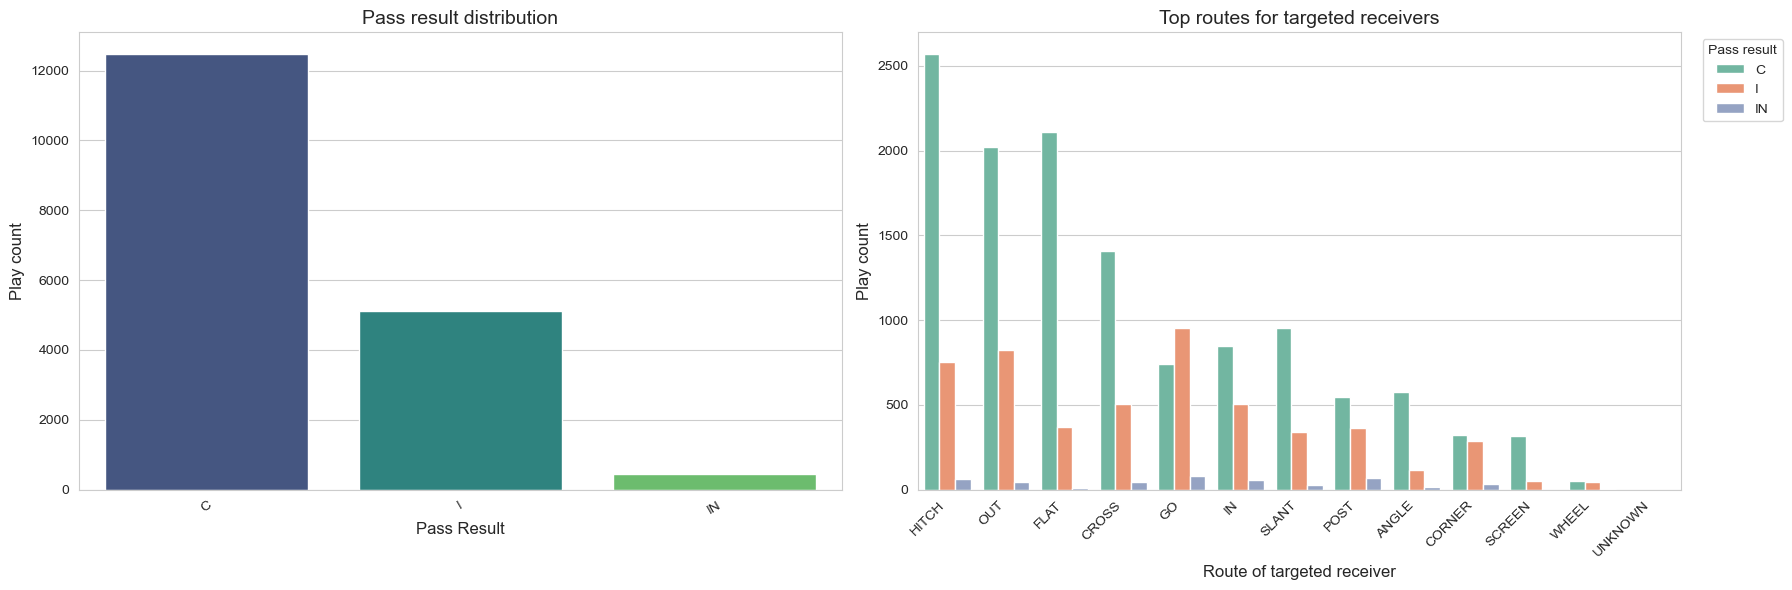

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
order = plays["pass_result"].value_counts().index if "pass_result" in plays.columns else None
sns.countplot(data=plays, x="pass_result", order=order, palette="viridis", ax=axes[0])
axes[0].set_title("Pass result distribution")
axes[0].set_xlabel("Pass Result")
axes[0].set_ylabel("Play count")
axes[0].tick_params(axis="x", rotation=30)
top_routes = plays["route_of_targeted_receiver"].fillna("UNKNOWN").value_counts().head(20).index
filt = plays[plays["route_of_targeted_receiver"].fillna("UNKNOWN").isin(top_routes)].copy()

if "pass_result" in plays.columns:
    sns.countplot(
        data=filt,
        x="route_of_targeted_receiver",
        hue="pass_result",
        order=top_routes,
        palette="Set2",
        ax=axes[1],
    )
    axes[1].legend(title="Pass result", bbox_to_anchor=(1.02, 1), loc="upper left")
else:
    sns.countplot(
        data=filt,
        x="route_of_targeted_receiver",
        order=top_routes,
        color="steelblue",
        ax=axes[1],
    )

axes[1].set_title("Top routes for targeted receivers")
axes[1].set_xlabel("Route of targeted receiver")
axes[1].set_ylabel("Play count")
axes[1].tick_params(axis="x", rotation=45)
for t in axes[1].get_xticklabels():
    t.set_ha("right")

plt.tight_layout()
plt.show()

**Pass result distribution**:
The dataset is dominated by completed passes, with incompletions occurring substantially less often and interceptions being rare. This confirms a strong class imbalance that is consistent with typical NFL pass outcomes.

**Top routes for targeted receivers**:
Targets are concentrated on short-to-intermediate routes (Hitch, Out, Flat, Cross, Slant), which account for the majority of completions and attempts. Deeper routes (Go, Post, Corner) appear less frequently and show a higher relative share of incompletions and interceptions, indicating that route depth and complexity systematically affect pass outcomes. Interesting thing to note is that Go is the only route for higher number of incompletions than completions, making it a clear outlier among the commonly targeted routes in terms of completion difficulty.

### Route Impact on EPA
Using the play-level table (`plays`), we group plays by route of the targeted receiver and pass result.

**Expected Points Added (EPA)** measures the change in a team’s expected points resulting from a play, relative to the game situation before the snap. Positive values indicate an increase in expected scoring value, while negative values indicate a decrease. For each route–result combination, we compute:
- the number of unique `play_id` values in that group, and  
- the mean of `expected_points_added` (and `yards_gained`, when available).


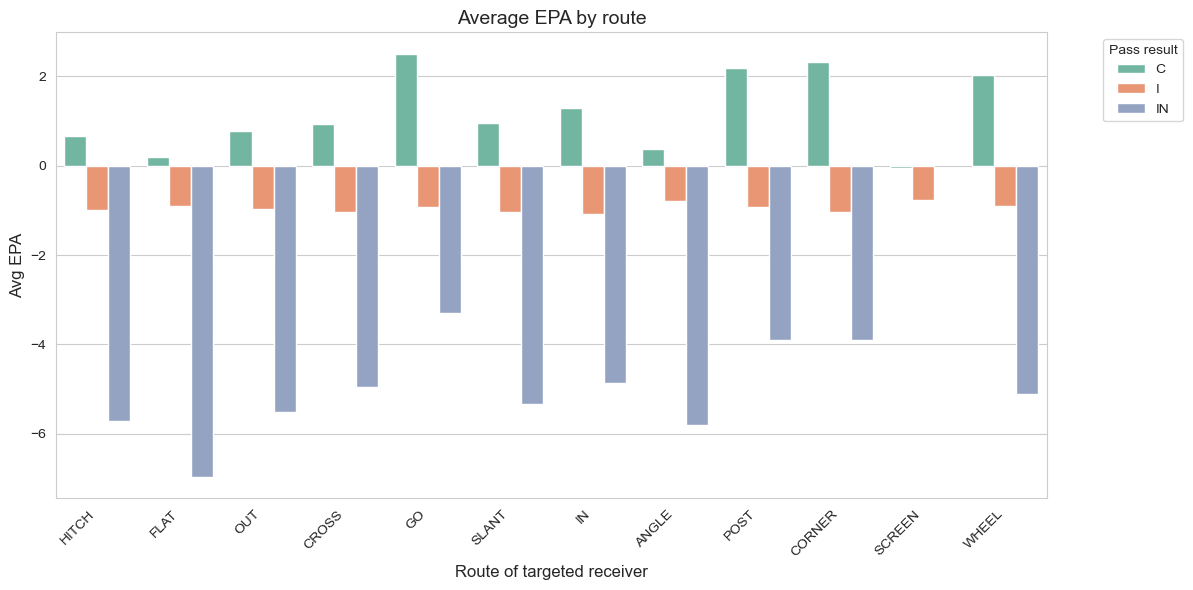

In [5]:
numeric_cols = [c for c in ['yards_gained', 'expected_points_added'] if c in plays.columns]
agg_spec = {
    'plays': ('play_id', 'nunique')
}
for col in numeric_cols:
    agg_spec[f'avg_{col}'] = (col, 'mean')

route_summary = (
    plays[['route_of_targeted_receiver', 'pass_result', 'play_id'] + numeric_cols]
    .dropna(subset=['route_of_targeted_receiver'])
    .groupby(['route_of_targeted_receiver', 'pass_result'])
    .agg(**agg_spec)
    .reset_index()
    .sort_values('plays', ascending=False)
)

if not route_summary.empty and 'avg_expected_points_added' in route_summary.columns:
    top_summary = route_summary
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=top_summary,
        x='route_of_targeted_receiver',
        y='avg_expected_points_added',
        hue='pass_result',
        palette='Set2'
    )
    plt.title('Average EPA by route')
    plt.xlabel('Route of targeted receiver')
    plt.ylabel('Avg EPA')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Pass result', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


1. **Average EPA is strongly stratified by pass result across all routes.**  
   For every route shown, completed passes have positive mean EPA, incompletions have moderately negative mean EPA, and interceptions have substantially more negative mean EPA, indicating a consistent ordering of outcomes by expected value.

2. **Conditional on completion, deeper and boundary-oriented routes tend to have higher average EPA.**  
   Routes such as Go, Post, Corner, and Wheel show higher positive EPA when completed compared to shorter routes like Hitch or Flat, reflecting greater play-level value among completed deep-route plays.

3. **Incompletions exhibit relatively uniform negative EPA across routes.**  
   The average EPA for incomplete passes varies only modestly by route, suggesting that route type has limited influence on the negative impact of an incompletion compared to the dominant effect of the outcome itself.

4. **Interceptions are uniformly costly across routes, with limited route-specific differentiation.**  
   While the magnitude of negative EPA for interceptions varies somewhat by route, all interception bars are strongly negative, indicating that interception cost dominates any route-level differences in expected points added.

### Field heatmap: positional density for wide receivers (WR)


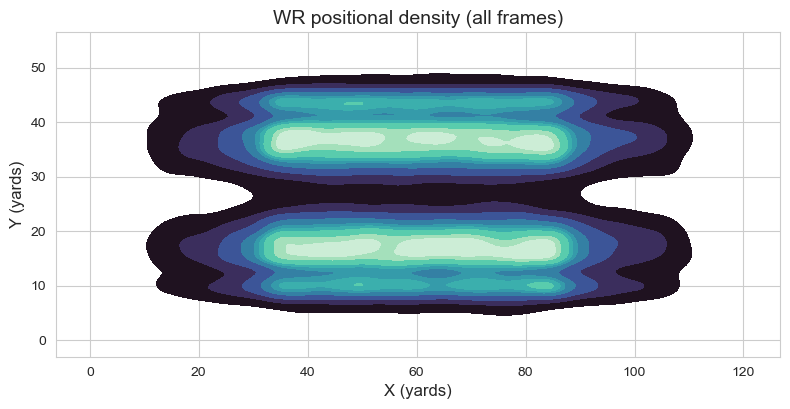

In [6]:
wr = tracking[tracking["position"] == "WR"]

plt.figure(figsize=(8, 6))
sns.kdeplot(data=wr, x="x", y="y", fill=True, cmap="mako", thresh=0.05)
plt.title("WR positional density (all frames)")
plt.xlabel("X (yards)")
plt.ylabel("Y (yards)")
plt.gca().set_aspect("equal", adjustable="box")
plt.tight_layout()
plt.show()

This plot shows the spatial distribution of wide receiver positions across all tracked frames. It indicates that wide receivers most frequently occupy two distinct horizontal bands along the width of the field, corresponding to alignments near the left and right sides rather than the center. Along the length of the field, receiver positions are spread broadly, reflecting movement across different depths over the course of plays rather than concentration at a single x-location.

### Speed and Acceleration for different Player Roles


/var/folders/4r/5d0jc8y57q7c0t149ds97srr0000gn/T/ipykernel_48119/638361153.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(role_metrics['player_role'], rotation=45, ha='right')


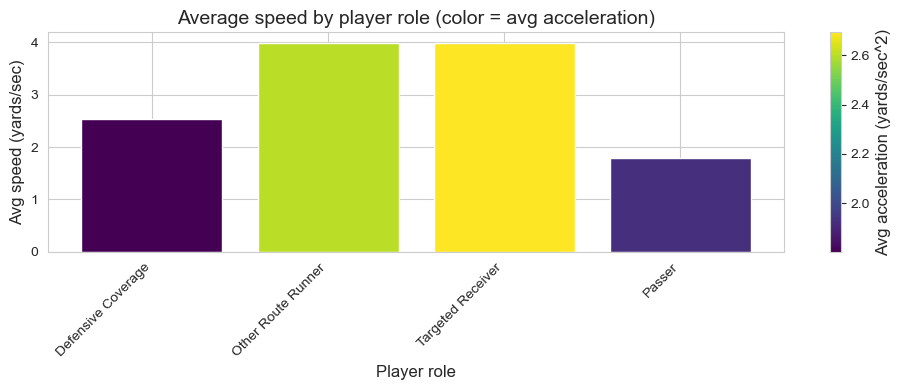

In [7]:
agg = tracking.groupby(['game_id', 'play_id', 'player_id']).agg(
    frames=('frame_id', 'nunique'),
    mean_speed=('s', 'mean'),
    max_speed=('s', 'max'),
    mean_acc=('a', 'mean'),
    max_acc=('a', 'max'),
    std_dir=('dir', 'std'),
    mean_x=('x', 'mean'),
    mean_y=('y', 'mean')
).reset_index()

role_metrics = (
    tracking.groupby('player_role')
    .agg(
        frames=('frame_id', 'count'),
        avg_speed=('s', 'mean'),
        max_speed=('s', 'max'),
        avg_acc=('a', 'mean')
    )
    .reset_index()
    .sort_values('frames', ascending=False)
)
fig, ax = plt.subplots(figsize=(10, 4))
norm = plt.Normalize(role_metrics['avg_acc'].min(), role_metrics['avg_acc'].max())
colors = plt.cm.viridis(norm(role_metrics['avg_acc'].values))
ax.bar(role_metrics['player_role'], role_metrics['avg_speed'], color=colors)
ax.set_title('Average speed by player role (color = avg acceleration)')
ax.set_xlabel('Player role')
ax.set_ylabel('Avg speed (yards/sec)')
ax.set_xticklabels(role_metrics['player_role'], rotation=45, ha='right')
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Avg acceleration (yards/sec^2)')
fig.tight_layout()
plt.show()


•	Average speed and acceleration differ clearly by player role, with targeted receivers exhibiting the highest mean speed and acceleration, followed closely by other route runners. Defensive coverage players and passers operate at lower motion intensity.

•	Passers form a distinct low-movement group, reflecting minimal downfield motion, whereas offensive receiving roles are characterized by higher speeds and more frequent acceleration events across tracked frames.

### Early Targeted Receiver Trajectory Clustering
Here we analyze whether early movement patterns of the targeted receiver form recurring geometric structures and whether these patterns are associated with differences in pass outcomes and play-level expected points added (EPA). We construct fixed-length trajectory vectors from the first few tracking frames of each targeted receiver, reducing their dimensionality using PCA, clustering them based on geometric similarity, and then linking the resulting clusters back to play-level outcomes and route labels for interpretation.


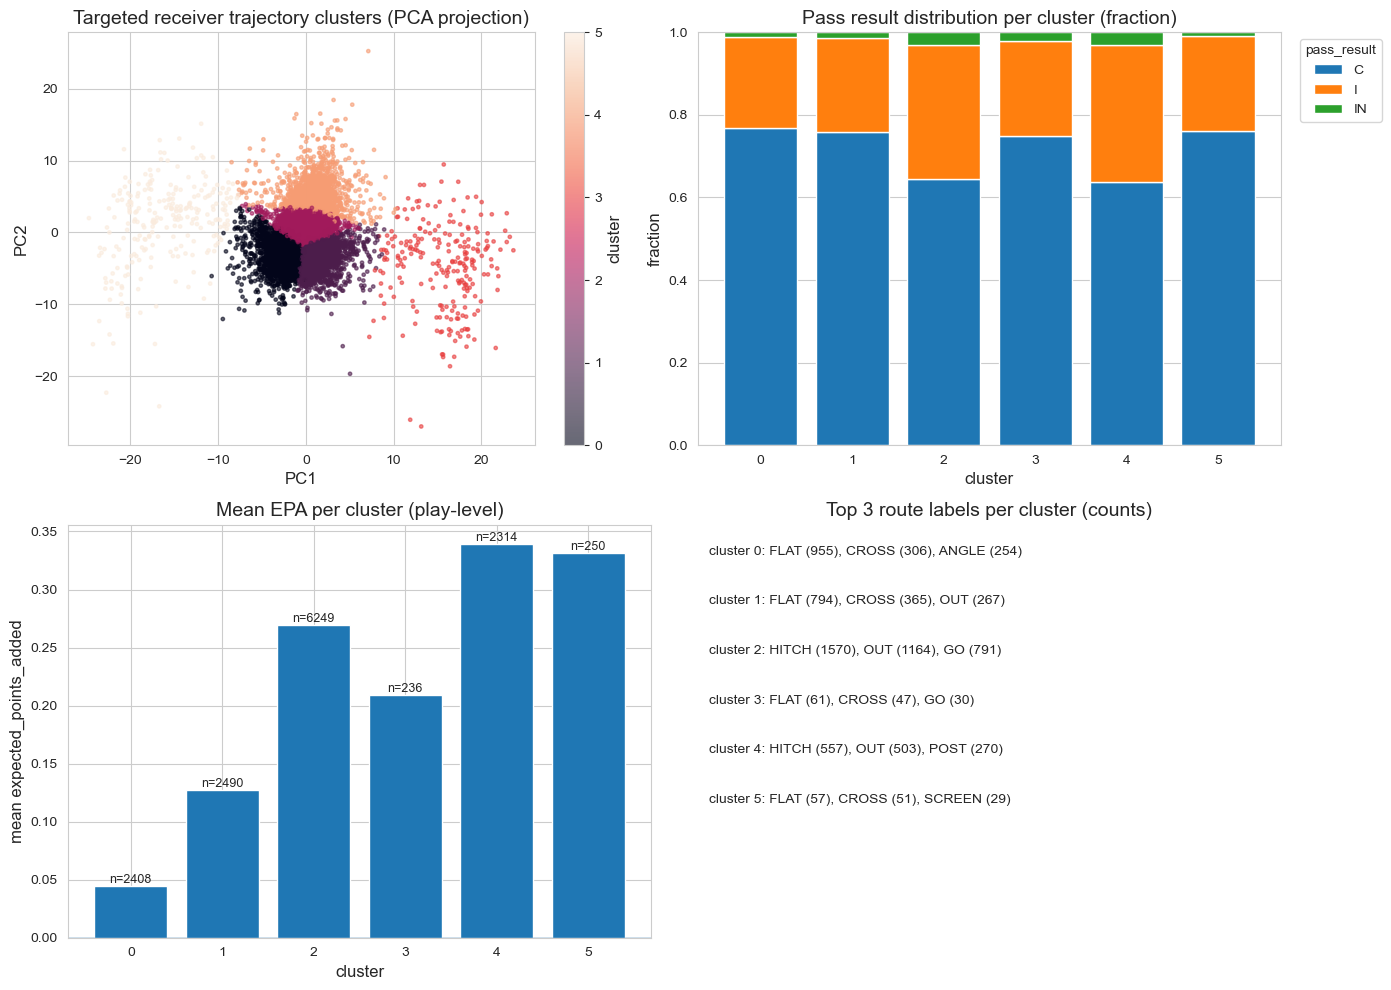

Trajectories clustered: 13947
Explained variance (cumulative, first up to 8 PCs): [0.465  0.9025 0.9552 0.9899 0.997  0.9982 0.9993 0.9996]


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

WINDOW = 15
N_CLUSTERS = 6
RANDOM_STATE = 42
tr = tracking.copy()

tr = tr[tr["player_role"].astype(str).eq("Targeted Receiver")]
need = {"game_id", "play_id", "player_id", "frame_id", "x", "y"}
missing = sorted(list(need - set(tr.columns)))
pdirection = tr["play_direction"].astype(str).str.lower()
left_mask = pdirection.eq("left")
tr.loc[left_mask, "x"] = 120.0 - tr.loc[left_mask, "x"]
tr.loc[left_mask, "y"] = 53.3 - tr.loc[left_mask, "y"]
start = tr.groupby(["game_id", "play_id"])["frame_id"].min().rename("startFrame")
tr = tr.join(start, on=["game_id", "play_id"])
tr["relFrame"] = tr["frame_id"] - tr["startFrame"]
tr = tr[tr["relFrame"].between(0, WINDOW - 1)]

pivot_x = tr.pivot_table(
    index=["game_id", "play_id", "player_id"],
    columns="relFrame",
    values="x",
    aggfunc="mean",
).reindex(columns=list(range(WINDOW)))

pivot_y = tr.pivot_table(
    index=["game_id", "play_id", "player_id"],
    columns="relFrame",
    values="y",
    aggfunc="mean",
).reindex(columns=list(range(WINDOW)))

route = pd.concat([pivot_x, pivot_y], axis=1).dropna()
Xx = route.iloc[:, :WINDOW].values
Xy = route.iloc[:, WINDOW:WINDOW * 2].values
x0 = Xx[:, [0]]
y0 = Xy[:, [0]]
X = np.concatenate([Xx - x0, Xy - y0], axis=1)

scaler = StandardScaler()
Xs = scaler.fit_transform(X)

pca = PCA(n_components=min(8, Xs.shape[1]), random_state=RANDOM_STATE)
Z = pca.fit_transform(Xs)

kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE, n_init=10)
labels = kmeans.fit_predict(Z)

Z2 = Z[:, :2]

idx = route.index.to_frame(index=False)
idx["cluster"] = labels

per_play_speed = agg.groupby(['game_id','play_id']).agg(play_max_speed=('max_speed','max'),
                                                        play_mean_speed=('mean_speed','mean')).reset_index()
plays = plays.merge(per_play_speed, on=['game_id','play_id'], how='left')
ctx = idx[["game_id", "play_id", "player_id", "cluster"]].copy()
keep = [c for c in ["game_id", "play_id", "route_of_targeted_receiver", "pass_result", "expected_points_added"] if c in plays.columns]
ctx = ctx.merge(plays[keep].drop_duplicates(["game_id", "play_id"]), on=["game_id", "play_id"], how="left")

fig = plt.figure(figsize=(14, 10))

ax1 = fig.add_subplot(2, 2, 1)
sc = ax1.scatter(Z2[:, 0], Z2[:, 1], c=labels, s=6, alpha=0.6)
ax1.set_title("Targeted receiver trajectory clusters (PCA projection)")
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
cb = fig.colorbar(sc, ax=ax1)
cb.set_label("cluster")

ax2 = fig.add_subplot(2, 2, 2)
pr = (
    ctx.dropna(subset=["pass_result"])
    .groupby(["cluster", "pass_result"])
    .size()
    .unstack(fill_value=0)
)
pr_frac = pr.div(pr.sum(axis=1), axis=0)

x = np.arange(pr_frac.shape[0])
bottom = np.zeros(pr_frac.shape[0])
for col in pr_frac.columns:
    ax2.bar(x, pr_frac[col].values, bottom=bottom, label=str(col))
    bottom += pr_frac[col].values

ax2.set_xticks(x)
ax2.set_xticklabels([str(i) for i in pr_frac.index])
ax2.set_ylim(0, 1)
ax2.set_title("Pass result distribution per cluster (fraction)")
ax2.set_xlabel("cluster")
ax2.set_ylabel("fraction")
ax2.legend(title="pass_result", bbox_to_anchor=(1.02, 1), loc="upper left")

ax3 = fig.add_subplot(2, 2, 3)
epa = (
    ctx.dropna(subset=["expected_points_added"])
    .groupby("cluster")["expected_points_added"]
    .agg(["count", "mean"])
)
ax3.bar(epa.index.astype(str), epa["mean"].values)
ax3.axhline(0, linewidth=1)
ax3.set_title("Mean EPA per cluster (play-level)")
ax3.set_xlabel("cluster")
ax3.set_ylabel("mean expected_points_added")
for i, (k, row) in enumerate(epa.iterrows()):
    ax3.text(i, row["mean"], f"n={int(row['count'])}", ha="center",
                va="bottom" if row["mean"] >= 0 else "top", fontsize=9)
ax4 = fig.add_subplot(2, 2, 4)
top = (
    ctx.dropna(subset=["route_of_targeted_receiver"])
    .groupby(["cluster", "route_of_targeted_receiver"])
    .size()
    .rename("n")
    .reset_index()
    .sort_values(["cluster", "n"], ascending=[True, False])
)
top3 = top.groupby("cluster").head(3)

ax4.axis("off")
ax4.set_title("Top 3 route labels per cluster (counts)")
y = 0.95
for k in sorted(top3["cluster"].unique()):
    rows = top3[top3["cluster"] == k]
    s = ", ".join([f"{r} ({n})" for r, n in zip(rows["route_of_targeted_receiver"], rows["n"])])
    ax4.text(0.02, y, f"cluster {k}: {s}", fontsize=10, va="top")
    y -= 0.12

plt.tight_layout()
plt.show()

print("Trajectories clustered:", len(route))
print("Explained variance (cumulative, first up to 8 PCs):", np.round(np.cumsum(pca.explained_variance_ratio_), 4))

From this output, we gain the following insights:

- **Early targeted-receiver trajectories cluster into distinct geometric patterns**, as shown by the PCA projection, indicating recurring shapes in early movement that are not purely random.

- **Trajectory clusters exhibit different pass result compositions**, with noticeable variation in completion vs. incompletion fractions across clusters, while interceptions remain rare in all clusters.

- **Mean EPA varies substantially by cluster**, suggesting that early trajectory shape is associated with differences in play-level value, even when aggregated over many plays.

- **Clusters are not equivalent to route labels**, as each cluster contains a mix of routes and the same route appears across multiple clusters, indicating that route annotations do not fully capture early movement geometry.

### Ball vs. Targeted Receiver Distance Error by Route
Align tracking data for the flagged target (`player_to_predict`) with the ball landing coordinates
to quantify spatial error at the catch point across routes and outcomes.

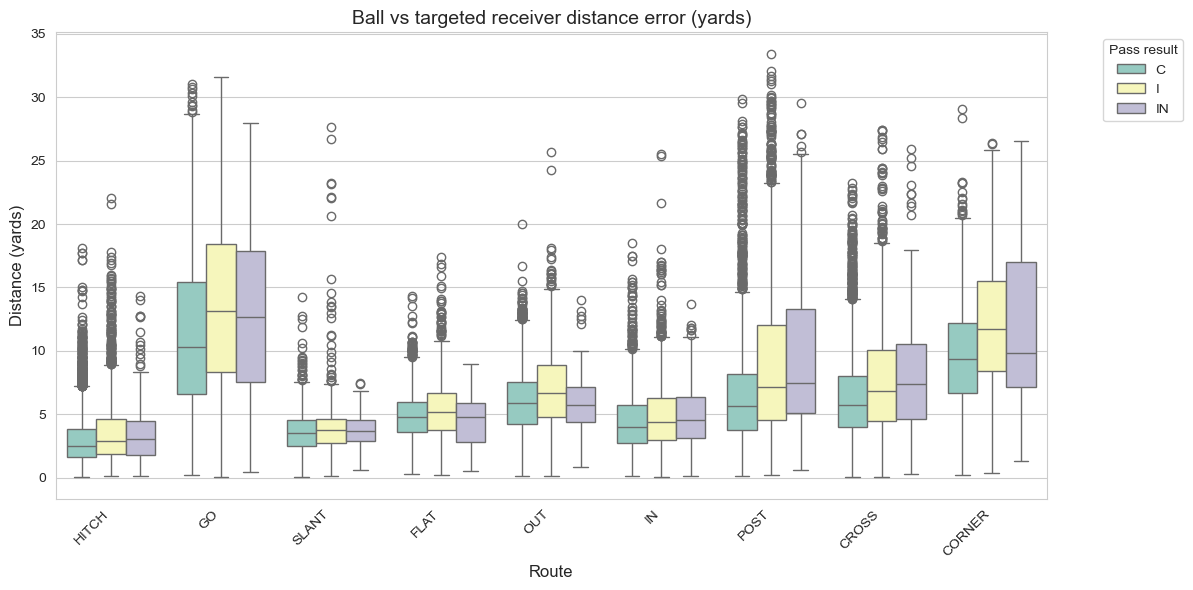

In [9]:
targeted_tracks = tracking[tracking['player_to_predict']].copy()

targeted_last = targeted_tracks.sort_values('frame_id').groupby(['game_id', 'play_id', 'player_id', 'week']).tail(1)
ball_last = ball_targets.sort_values('frame_id').groupby(['game_id', 'play_id', 'player_id', 'week']).tail(1)
ball_last = ball_last.rename(columns={'x': 'ball_x', 'y': 'ball_y'})
targeted_last = targeted_last.rename(columns={'x': 'player_x', 'y': 'player_y'})
arrival = targeted_last.merge(
    ball_last[['game_id', 'play_id', 'player_id', 'week', 'ball_x', 'ball_y']],
    on=['game_id', 'play_id', 'player_id', 'week'],
    how='inner'
)
arrival['ball_dx'] = arrival['ball_x'] - arrival['player_x']
arrival['ball_dy'] = arrival['ball_y'] - arrival['player_y']
arrival['ball_distance_error'] = np.sqrt(arrival['ball_dx']**2 + arrival['ball_dy']**2)


context_cols = [c for c in ['route_of_targeted_receiver', 'pass_result', 'yards_gained'] if c in plays.columns]
arrival = arrival.merge(
    plays[['game_id', 'play_id'] + context_cols],
    on=['game_id', 'play_id'],
    how='left'
)

route_error = (
    arrival.dropna(subset=['route_of_targeted_receiver'])
    .groupby(['route_of_targeted_receiver', 'pass_result'])
    .agg(
        plays=('game_id', 'count'),
        mean_error=('ball_distance_error', 'mean'),
        median_error=('ball_distance_error', 'median')
    )
    .reset_index()
    .sort_values('plays', ascending=False)
)
top_routes = route_error['route_of_targeted_receiver'].head(15).tolist()
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=arrival[arrival['route_of_targeted_receiver'].isin(top_routes)],
    x='route_of_targeted_receiver',
    y='ball_distance_error',
    hue='pass_result',
    palette='Set3'
)
plt.title('Ball vs targeted receiver distance error (yards)')
plt.xlabel('Route')
plt.ylabel('Distance (yards)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Pass result', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


This plot shows the distribution of the final spatial distance between the ball landing location and the targeted receiver’s position, grouped by route and pass result.

- **Distance error varies substantially by route**, with shorter routes (e.g., HITCH, SLANT, FLAT) exhibiting tighter distributions and lower median errors, while deeper routes (e.g., GO, POST, CORNER) show wider spreads and larger typical errors.

- **Completed passes generally correspond to smaller distance errors** across all routes, whereas incomplete and intercepted passes tend to have higher median errors and heavier upper tails.

- **Deeper and breaking routes display greater variability**, indicating increased spatial dispersion between the receiver and ball location at the end of the play compared to underneath routes.

## II. Analyzing Defensive Closing Speed and Separation in Incomplete Passes
### Problem Statement
Let's try to examine what are the factors involved in an incomplete pass. Is it defender's closing speed that leads to a better interception of a pass and make it incomplete? If yes, what is the correlation?
 
**Intuition:** If a defender is recovering from a poor position on the field, they will most likely sprint and be out of phase instead of providing proactive coverage. By focusing on the "Ball-in-Air" window of passes, we will show that the fastest defensive sprints often signal a coverage breakdown.

To address this problem, we need the following metrics:
- **Separation distance** - How much distance is there between receiver and defender? 'Output' dataset gives us raw coordinates $(x, y)$ but not the actual velocity vectors, we have to derive the movement ourselves. First, we calculate the gap (Euclidean Separation). Then, we measure the straight-line distance between the targeted receiver $(x_t, y_t)$ and every defender $(x_d, y_d)$ on the field. $$d = \sqrt{(x_d - x_t)^2 + (y_d - y_t)^2}$$
- **Closing speed** - How fast is this gap disappearing? We look at how the separation changes from one frame to the next. Since the data captures for every 0.1 seconds, we calculate the change over time:$$v = - \frac{(d_{t} - d_{t-1})}{0.1}$$Note: We apply a negative sign here to align the math with intuition: if the gap is shrinking (a negative change in distance), it registers as a positive closing speed.
- **Out-of-phase score (or Panic Index)** - This functions as a metric to diagnose if a defender generates high closing speed after losing positional leverage (high separation). It is defined as a product of separation distance and closing speed. $$
\text{OOP Score} = \text{Separation Distance} \times \text{Closing Speed}
$$

In [10]:
import os
import gc
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import matplotlib.patches as patches
from scipy.signal import savgol_filter as sgolay

In [11]:
base_dir = DATA_DIR
train_dir = TRAIN_DIR

meta_df = pd.read_csv(os.path.join(base_dir, 'supplementary_data.csv'), low_memory=False)
all_weeks = []

print("Processing input and output csvs")
for week in range(1, 19):
    week_str = f"{week:02d}"
    try:
        output_path = os.path.join(train_dir, f'output_2023_w{week_str}.csv')
        week_out = pd.read_csv(output_path)
        
        input_path = os.path.join(train_dir, f'input_2023_w{week_str}.csv')
        cols = ['game_id', 'play_id', 'nfl_id', 'player_name', 'player_role', 'player_side', 'player_position']
        week_in = pd.read_csv(input_path, usecols=cols).drop_duplicates(['game_id', 'play_id', 'nfl_id'])
        
        merged = week_out.merge(week_in, on=['game_id', 'play_id', 'nfl_id'], how='left')
        all_weeks.append(merged)
        
        del week_out, week_in, merged
        gc.collect()
        
    except FileNotFoundError:
        print(f"  - Week {week_str} skipped (Expected if file doesn't exist)", end="\r") 
        continue

ball_in_air = pd.concat(all_weeks, ignore_index=True)
del all_weeks
gc.collect()

ball_in_air = ball_in_air.merge(
    meta_df[['game_id', 'play_id', 'pass_result']], 
    on=['game_id', 'play_id'], how='left'
)

print(f"All csvs merged into df. Total Frames: {len(ball_in_air):,}")

Processing input and output csvs
All csvs merged into df. Total Frames: 562,936


Calculating separation distance. Stored in `dist_smooth` column in `closest_df`

In [12]:
targets = ball_in_air[ball_in_air['player_role'] == 'Targeted Receiver'][['game_id', 'play_id', 'frame_id', 'x', 'y']]
targets = targets.rename(columns={'x': 't_x', 'y': 't_y'})
defenders = ball_in_air[ball_in_air['player_side'] == 'Defense'].copy()
analysis_df = defenders.merge(targets, on=['game_id', 'play_id', 'frame_id'], how='inner')

# Calculating Raw Distance
analysis_df['dist'] = np.sqrt((analysis_df['x'] - analysis_df['t_x'])**2 + (analysis_df['y'] - analysis_df['t_y'])**2)

# Smoothening the distance to remove any jitters between frames
def smooth_distance(series):
    if len(series) >= 5:
        return sgolay(series, window_length=5, polyorder=2)
    return series

analysis_df['dist_smooth'] = analysis_df.groupby(['game_id', 'play_id', 'nfl_id'])['dist'].transform(smooth_distance)

# Filtering to the closest defender for each receiver
analysis_df = analysis_df.sort_values(['game_id', 'play_id', 'frame_id', 'dist_smooth'])
closest_df = analysis_df.drop_duplicates(['game_id', 'play_id', 'frame_id']).copy()

Calculating closing speed by performing derivative on the separation distance data

In [13]:
closest_df = closest_df.sort_values(['game_id', 'play_id', 'frame_id'])
closest_df['dist_chg'] = closest_df['dist_smooth'].diff()
closest_df['same_play'] = closest_df['play_id'] == closest_df['play_id'].shift(1)
closest_df.loc[~closest_df['same_play'], 'dist_chg'] = np.nan
closest_df['closing_speed'] = -(closest_df['dist_chg'] / 0.1)
closest_df['oop_score'] = closest_df['dist_smooth'] * closest_df['closing_speed']

closest_df[['player_name', 'dist', 'dist_smooth', 'closing_speed', 'oop_score']].dropna().sample(5)

,player_name,dist,dist_smooth,closing_speed,oop_score
366484,Otis Reese,0.760592,0.763621,0.322878,0.246556
4437,Cam Taylor-Britt,0.830241,0.840152,-0.197701,-0.166099
366932,Brandon Facyson,0.622656,0.615980,2.980887,1.836167
265744,Deane Leonard,1.416757,1.412889,0.576137,0.814018
45786,Cole Holcomb,6.519586,6.509850,-3.691858,-24.033444


Measuring statistical significance of this hypothesis

In [14]:
if 'yards_to_go' not in closest_df.columns:
    closest_df = closest_df.merge(
        meta_df[['game_id', 'play_id', 'yards_to_go']], 
        on=['game_id', 'play_id'], 
        how='left'
    )

print("Statistical Significance Test")
group_c = closest_df[closest_df['pass_result'] == 'C']['closing_speed'].dropna()
group_i = closest_df[closest_df['pass_result'] == 'I']['closing_speed'].dropna()

t_stat, p_val = stats.ttest_ind(group_c, group_i, equal_var=False)

print(f"Complete Pass Avg Speed (Complete): {group_c.mean():.2f} yds/s")
print(f"Incomplete Pass Avg Speed: {group_i.mean():.2f} yds/s")
print(f"Difference: {group_c.mean() - group_i.mean():.2f} yds/s")
print(f"P-Value: {p_val:.2e}")

print("\nSensitivity Test (Deep Passes > 10 Yards)")
deep_c = closest_df[(closest_df['pass_result'] == 'C') & (closest_df['yards_to_go'] > 10)]['closing_speed'].mean()
deep_i = closest_df[(closest_df['pass_result'] == 'I') & (closest_df['yards_to_go'] > 10)]['closing_speed'].mean()

print(f"Deep Pass Avg Speed (C): {deep_c:.2f}")
print(f"Deep Pass Avg Speed (I): {deep_i:.2f}")
print(f"Gap: {deep_c - deep_i:.2f}")

Statistical Significance Test
Complete Pass Avg Speed (Complete): 0.90 yds/s
Incomplete Pass Avg Speed: 0.67 yds/s
Difference: 0.23 yds/s
P-Value: 5.22e-69

Sensitivity Test (Deep Passes > 10 Yards)
Deep Pass Avg Speed (C): 1.25
Deep Pass Avg Speed (I): 0.91
Gap: 0.34


When we aggregated the maximum closing speed for every play (Weeks 1–18) and compared it against the pass result, a statistically significant pattern emerged:

* **Incompletions (Defensive Wins):** Average Max Speed = **0.67 yds/sec**
* **Completions (Defensive Losses):** Average Max Speed = **0.90 yds/sec**

### Statistical Validation
This **0.23 yds/sec difference** in speed between winning and losing plays suggests a fundamental truth about coverage. A T-test confirmed this result is statistically significant with a P-value of:
$$\text{P-value} = 5.22 \times 10^{-69}$$

### Sensitivity Analysis (Deep Passes)
This value is very tiny, confirming that the divergence in defensive speed profiles is not statistical noise but a **highly consistent and robust characteristic of NFL coverage.**

To test if this paradox holds in high-leverage situations, we isolated the **Deep Pass** category (plays where yards-to-go > 10). The disparity was even more pronounced:

* **Deep Pass Completions (Losing Plays):** 1.25 yds/sec
* **Deep Pass Incompletions (Winning Plays):** 0.91 yds/sec
* **The Final Gap:** **0.34 yds/sec**

This confirms that the "Panic Index" is most profound when the stakes are highest, where the cost of being "Out-of-Phase" requires the most drastic (and ultimately unsuccessful) recovery effort.

### Does Closing Speed Prevent Catches?
To evaluate the effectiveness of defensive speed, we aggregated the Maximum Closing Speed for every play and compared it against the play's outcome.

**The Result:**
As visualized below, Completed passes (C) feature a higher average maximum closing speed than Incomplete passes (I). This supports our hypothesis that high defensive velocity is a "lagging indicator": a symptom of a defender sprinting to recover from a lost position.

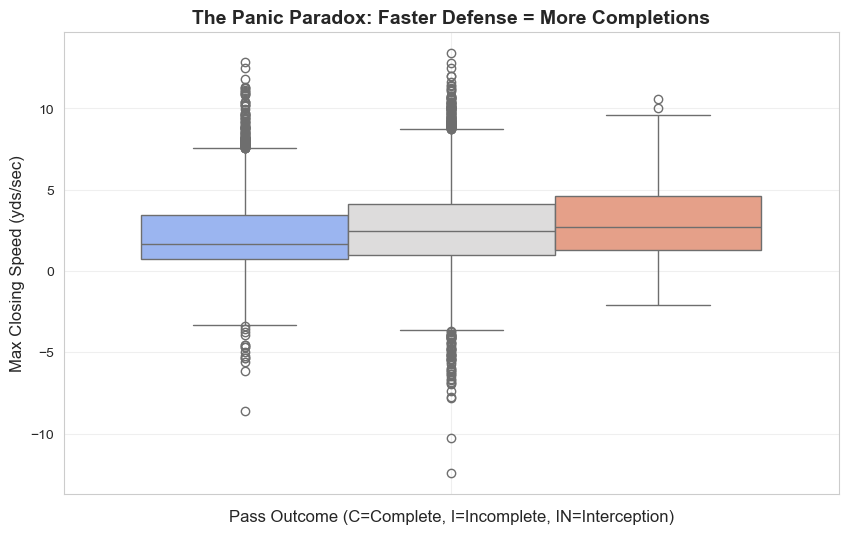

Average Max Closing Speed by Outcome:
pass_result
C     2.628208
I     2.265648
IN    3.162629
Name: closing_speed, dtype: float64


In [15]:
# Identify Max Speed per play
idx = closest_df.groupby(['game_id', 'play_id'])['closing_speed'].idxmax()
play_max_speed = closest_df.loc[idx].copy()

if 'pass_result' not in play_max_speed.columns:
    play_max_speed = play_max_speed.merge(
        ball_in_air[['game_id', 'play_id', 'pass_result']].drop_duplicates(), 
        on=['game_id', 'play_id']
    )

plt.figure(figsize=(10, 6))
sns.boxplot(data=play_max_speed, hue='pass_result', y='closing_speed', palette='coolwarm', legend=False)

plt.title("The Panic Paradox: Faster Defense = More Completions", fontsize=14, fontweight='bold')
plt.ylabel("Max Closing Speed (yds/sec)")
plt.xlabel("Pass Outcome (C=Complete, I=Incomplete, IN=Interception)")
plt.grid(True, alpha=0.3)

plt.savefig('panic_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

print("Average Max Closing Speed by Outcome:")
print(play_max_speed.groupby('pass_result')['closing_speed'].mean())

Top 10 'Panicked' Defenders Leaderboard
 nfl_id         player_name position  oop_score
  52475       Julian Okwara      OLB  40.717062
  55999            Jay Ward       SS  34.328004
  42368       Shaq Thompson      MLB  31.124344
  54686 Tariq Castro-Fields       CB  27.980906
  52410         Chase Young      OLB  24.197449
  55043         Jake Hansen      OLB  24.071610
  47939      Justin Hollins      OLB  21.565549
  44865          Teez Tabor       FS  20.724589
  55047    Tristin McCollum       SS  18.728115
  56111           D.J. Ivey       CB  18.346510


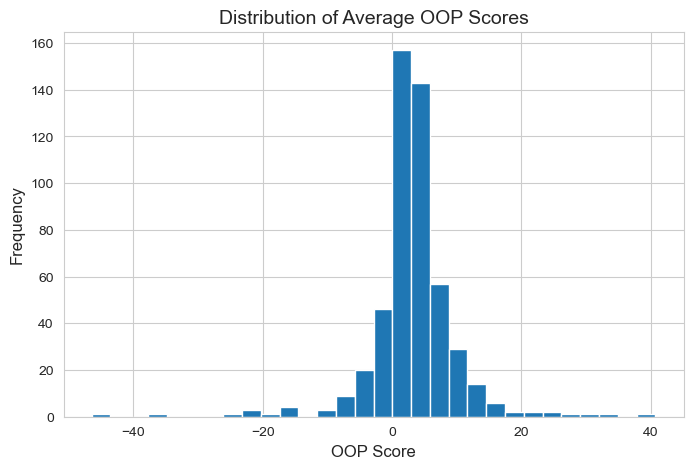

In [16]:
if 'closest_df' not in globals() or closest_df.empty:
    raise RuntimeError("closest_df not found. Please run metric calculation cell.")

# Define coverage positions (standard NFL abbreviations)
COVERAGE_POSITIONS = {'CB', 'S', 'FS', 'SS', 'LB', 'MLB', 'OLB'}

# Filter to defenders in coverage roles
coverage_df = closest_df[
    (closest_df['player_side'] == 'Defense') &
    (closest_df['player_position'].isin(COVERAGE_POSITIONS)) &
    (closest_df['oop_score'].notna())
]

# Aggregate mean OOP score per player
leaderboard = (
    coverage_df
    .groupby(['nfl_id', 'player_name', 'player_position'])['oop_score']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

leaderboard = leaderboard.rename(columns={'player_position': 'position'})

# Display top 10 panicked players
print("Top 10 'Panicked' Defenders Leaderboard")
print(leaderboard.head(10).to_string(index=False))

plt.figure(figsize=(8, 5))
plt.hist(leaderboard['oop_score'], bins=30)
plt.xlabel('OOP Score')
plt.ylabel('Frequency')
plt.title('Distribution of Average OOP Scores')
plt.show()

### Performance based on OOP Score

The O.O.P. Score penalizes bursts of speed that occur only after a defender has already lost leverage. Rather than rewarding raw athleticism, the metric emphasizes positional efficiency shifting evaluation from volume of speed to quality of positioning.

Based on empirical analysis across the full season, we propose the following performance tiers:

| Tier | O.O.P. Score | Interpretation |
|------|--------------|----------------|
| **In-Phase** | < 15 | Controlled, proactive coverage. The defender maintains tight positioning, rendering high-speed recovery unnecessary. Reflects high technical efficiency. |
| **Recovery Mode** | 15 – 40 | The defender has lost initial leverage and is now accelerating to re-establish proximity. Competitive but reactive—common on well-executed offensive routes. |
| **Panic State** | > 40 | The defender is sprinting at high velocity (>10 yds/s) while still >4 yards from the receiver. Indicates a complete breakdown in coverage; speed is maximal but futile. |

Intuitively, this score quantifies the defender's panic. A panicked player will most likely be further from a favorable position (high separation distance) and will run faster to close that gap (high closing speed). Hence, this also signifies **Panic Index**.

![alt text](panic_concept_diagram_v2_clean.png "Title")

### Visualizing the "Ball-in-Air" Window

To validate that our metrics reflect real on-field dynamics,and not data artifacts. We animated the play with the **highest recorded closing speed** in our dataset (Weeks 1–9). This play exemplifies the **“Panic State”**: a defender sprinting at maximum effort while significantly out of phase with the targeted receiver.

The animation (saved as `panic_play_enhanced.gif`) includes:
- **All offensive and defensive players**, colored red and blue respectively,
- The **targeted receiver** highlighted with a gold star,
- The **closest defender** (as identified by our O.O.P. pipeline) marked in cyan,
- A **dashed white line** connecting the two to visualize separation distance in real time,
- A live display of **separation distance, closing speed, and O.O.P. Score** for each frame,
- A clear label marking the **frame of peak closing speed**,
- Final play outcome (**Completion** or **Incompletion**) shown in the last few frames.

This visualization confirms that extreme closing speed in our top-ranked play occurs during a genuine recovery sprint validating both the **kinematic derivation** and the **diagnostic power** of the O.O.P. Score. 

In [17]:
def create_football_field(linenumbers=True, endzones=True, figsize=(12, 6.33)):
    fig, ax = plt.subplots(1, figsize=figsize)
    rect = patches.Rectangle((0, 0), 120, 53.3, facecolor='darkgreen', zorder=0)
    ax.add_patch(rect)
    ax.plot([0, 0, 120, 120, 0], [0, 53.3, 53.3, 0, 0], color='white', linewidth=2)
    for x in range(10, 120, 10):
        ax.plot([x, x], [0, 53.3], color='white', alpha=0.5, linewidth=1)
    for x in range(10, 120):
        if x % 10 == 0:
            continue
        ax.plot([x, x], [53.3 - 1, 53.3], color='white', alpha=0.5)
        ax.plot([x, x], [0, 1], color='white', alpha=0.5)
        ax.plot([x, x], [23, 24], color='white', alpha=0.5)
        ax.plot([x, x], [29.3, 30.3], color='white', alpha=0.5)
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x if x <= 50 else 120 - x
            ax.text(x, 5, str(numb), ha='center', fontsize=20, color='white')
            ax.text(x, 53.3 - 5, str(numb), ha='center', fontsize=20, color='white', rotation=180)
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3, facecolor='blue', alpha=0.2, zorder=0)
        ez2 = patches.Rectangle((110, 0), 10, 53.3, facecolor='blue', alpha=0.2, zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    ax.set_xlim(0, 120)
    ax.set_ylim(-5, 58.3)
    ax.axis('off')
    return fig, ax

top_play_row = closest_df.sort_values('closing_speed', ascending=False).iloc[0]
test_game_id = int(top_play_row['game_id'])
test_play_id = int(top_play_row['play_id'])
max_speed_frame = int(top_play_row['frame_id'])

outcome = meta_df[
    (meta_df['game_id'] == test_game_id) & 
    (meta_df['play_id'] == test_play_id)
]['pass_result'].iloc[0]

print(f"Animating 'Top Panic' Play: Game {test_game_id}, Play {test_play_id}")
print(f"Outcome: {'Completion' if outcome == 'C' else 'Incompletion'}")
print(f"Max Closing Speed at Frame: {max_speed_frame}")

play_tracking = ball_in_air[
    (ball_in_air['game_id'] == test_game_id) & 
    (ball_in_air['play_id'] == test_play_id)
].copy()

# Get frames (Ball-in-Air window only)
frames_to_use = sorted(play_tracking['frame_id'].unique())
last_frame = frames_to_use[-1]

target_info = play_tracking[play_tracking['player_role'] == 'Targeted Receiver'][['frame_id', 'x', 'y']].set_index('frame_id')

oop_play = closest_df[
    (closest_df['game_id'] == test_game_id) &
    (closest_df['play_id'] == test_play_id)
][['frame_id', 'dist_smooth', 'closing_speed', 'oop_score', 'player_name']].set_index('frame_id')

def animate_play_enhanced(df, target_info, oop_play, frames, max_speed_frame, outcome, last_frame):
    fig, ax = create_football_field()
    
    off_scatter = ax.scatter([], [], c='red', s=100, label='Offense', zorder=5, edgecolors='white')
    def_scatter = ax.scatter([], [], c='blue', s=100, label='Defense', zorder=5, edgecolors='white')
    target_scatter = ax.scatter([], [], c='gold', s=200, marker='*', label='Targeted Receiver', zorder=6, edgecolors='black')
    closest_scatter = ax.scatter([], [], c='cyan', s=180, edgecolors='black', linewidth=2, zorder=7)
    
    sep_line, = ax.plot([], [], color='white', linestyle='--', linewidth=2, alpha=0.7, zorder=4)
    
    info_txt = ax.text(10, 50, '', fontsize=11, color='white', fontweight='bold',
                       bbox=dict(facecolor='black', alpha=0.6))
    max_speed_txt = ax.text(60, 50, '', fontsize=13, color='orange', fontweight='bold',
                            bbox=dict(facecolor='black', alpha=0.7), visible=False)
    outcome_txt = ax.text(60, 45, '', fontsize=12, color='lime' if outcome == 'C' else 'white',
                          fontweight='bold', bbox=dict(facecolor='black', alpha=0.7), visible=False)
    
    ax.legend(loc='upper right')
    
    def update(frame):
        current = df[df['frame_id'] == frame]
        off_data = current[current['player_side'] == 'Offense']
        def_data = current[current['player_side'] == 'Defense']
        
        off_scatter.set_offsets(off_data[['x', 'y']].values if not off_data.empty else np.empty((0, 2)))
        def_scatter.set_offsets(def_data[['x', 'y']].values if not def_data.empty else np.empty((0, 2)))
        
        if frame in target_info.index:
            rx, ry = target_info.loc[frame, ['x', 'y']]
            target_scatter.set_offsets([[rx, ry]])
        else:
            target_scatter.set_offsets(np.empty((0, 2)))
        
        if frame in oop_play.index:
            row = oop_play.loc[frame]
            dist = row['dist_smooth']
            speed = row['closing_speed']
            oop = row['oop_score']
            d_name = row['player_name']
            
            def_pos = current[(current['player_side'] == 'Defense') & (current['player_name'] == d_name)]
            if not def_pos.empty:
                dx, dy = def_pos.iloc[0]['x'], def_pos.iloc[0]['y']
                closest_scatter.set_offsets([[dx, dy]])
                if frame in target_info.index:
                    rx, ry = target_info.loc[frame, ['x', 'y']]
                    sep_line.set_data([dx, rx], [dy, ry])
                else:
                    sep_line.set_data([], [])
            else:
                closest_scatter.set_offsets(np.empty((0, 2)))
                sep_line.set_data([], [])
            
            info_txt.set_text(
                f"Frame: {frame}\n"
                f"Separation: {dist:.1f} yds\n"
                f"Closing Speed: {speed:.1f} yds/s\n"
                f"OOP Score: {oop:.1f}"
            )
        else:
            closest_scatter.set_offsets(np.empty((0, 2)))
            sep_line.set_data([], [])
            info_txt.set_text(f"Frame: {frame}\n— No OOP data —")
        
        # Highlight max speed frame
        if frame == max_speed_frame:
            max_speed_txt.set_text("MAX CLOSING SPEED")
            max_speed_txt.set_visible(True)
        else:
            max_speed_txt.set_visible(False)
        
        # Show outcome in last 3 frames
        if frame >= last_frame - 2:
            outcome_txt.set_text("COMPLETION" if outcome == 'C' else "INCOMPLETION")
            outcome_txt.set_visible(True)
        else:
            outcome_txt.set_visible(False)
        
        return off_scatter, def_scatter, target_scatter, closest_scatter, sep_line, info_txt, max_speed_txt, outcome_txt

    anim = animation.FuncAnimation(fig, update, frames=frames, interval=100, blit=False, repeat=False)
    plt.close()
    return anim

anim = animate_play_enhanced(
    play_tracking,
    target_info,
    oop_play,
    frames_to_use,
    max_speed_frame,
    outcome,
    last_frame
)

anim.save('panic_play_enhanced.gif', writer='pillow', fps=10)
print("Animation saved for panic play")

# Display in notebook
HTML(anim.to_jshtml())

Animating 'Top Panic' Play: Game 2023100107, Play 4000
Outcome: Completion
Max Closing Speed at Frame: 2
Animation saved for panic play


Link to the gif since the PDF doesn't support it: https://github.com/glitched-shadeslayer/nfl-pass-play-analytics/blob/main/panic_play_enhanced.gif 

### Conclusion

The Out-of-Phase Score (or Panic Index) presents evaluation method for defensive plays: the fastest moments often reveal the deepest flaws. By quantifying when speed is a symptom of being “Out of Phase,” it shifts focus from raw athleticism to **positional intelligence** a critical but often overlooked dimension of coverage quality.

Future work should prioritize using the O.O.P. Score for predictive frameworks for real-time coaching and broadcast applications.